Libraries and Dependencies

In [1]:
# 📦 Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
import xgboost as xgb
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
import os

# 🚨 Ignore Warnings
warnings.filterwarnings("ignore")

# 📂 Show data files in directory (if you're using Kaggle or a local dataset folder)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
!pip install category_encoders

Data Loading and Preprocessing

In [3]:
import pandas as pd

# Loading training data
data = pd.read_csv("/content/drive/MyDrive/train.csv")
data.head()



,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,mw205674.txt,http://www.danangluxury.com,26,www.danangluxury.com,20.0,0.0,com,75.000000,1.000000,0.522907,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,712147.txt,https://www.leedstownhall.co.uk,30,www.leedstownhall.co.uk,23.0,0.0,uk,100.000000,0.875000,0.028555,...,0.0,0.0,1.0,37.0,41.0,46.0,104.0,3.0,93.0,1.0
2,806061.txt,https://www.mexicancafe.co.nz,28,www.mexicancafe.co.nz,21.0,0.0,nz,100.000000,0.857143,0.001993,...,1.0,0.0,0.0,14.0,4.0,14.0,51.0,0.0,7.0,1.0
3,164934.txt,https://www.usglassmag.com,25,www.usglassmag.com,18.0,0.0,com,100.000000,1.000000,0.522907,...,1.0,0.0,1.0,40.0,26.0,25.0,106.0,9.0,193.0,1.0
4,8131216.txt,https://cloudflare-ipfs.com/ipfs/bafybeicivf4l...,93,cloudflare-ipfs.com,19.0,0.0,com,23.030879,0.733333,0.522907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1. Approach 1 (Taking numerical features)

Null value check

In [4]:
# Checking for null values
data.isnull().sum()

,0
FILENAME,0
URL,0
URLLength,0
Domain,0
DomainLength,1
IsDomainIP,1
TLD,1
URLSimilarityIndex,1
CharContinuationRate,1
TLDLegitimateProb,1


In [5]:
# Dropping null values
data.dropna(inplace=True)

Encoding of categorical data

In [6]:
# Checking for unique values of categorical data
data[['FILENAME','URL','Domain','Title','TLD']].nunique()

,0
FILENAME,71742
URL,71708
Domain,68802
Title,61200
TLD,518


In [7]:
!pip install category_encoders


Since there are a lot of unique values, I used Target Encoding to encode the categorical data

In [8]:
from category_encoders import TargetEncoder

# Target encoding categorical data
encoder = TargetEncoder(cols = 'Domain')
encoder.fit(data['Domain'], data['label'])
data['Domain'] = encoder.transform(data['Domain'])

encoder = TargetEncoder(cols = 'TLD')
encoder.fit(data['TLD'], data['label'])
data['TLD'] = encoder.transform(data['TLD'])

data[['Domain','TLD']]

,Domain,TLD
0,0.506885,0.621118
1,0.636993,0.947801
2,0.636993,0.921053
3,0.636993,0.621118
4,0.000531,0.621118
...,...,...
71738,0.506885,0.621118
71739,0.506885,0.621118
71740,0.636993,0.885767
71741,0.636993,0.621118


I dropped URL and Title since most of its content would be captured by Domain and TLD, and also because Title was 0 in many rows

In [9]:
data[data['Title']=='0'][['URL','Title']]

,URL,Title
4,https://cloudflare-ipfs.com/ipfs/bafybeicivf4l...,0
6,http://www.dyndns.icu,0
14,https://cloudflare-ipfs.com/ipfs/bafybeiaw42kb...,0
37,http://www.domno69.no-p.biz,0
41,http://www.dxtras.com,0
...,...,...
71717,http://www.vipecotton.com,0
71720,http://www.mpmts.com,0
71726,https://7change.ru,0
71738,http://www.2k3d.csqoy.com,0


In [10]:
# Dropping textual data except Domain and TLD
labels = data['label']
data = data.drop(['FILENAME','URL','Title'],axis=1)

# Checking for imbalance in label column
labels.value_counts()

,count
label,
1.0,41804
0.0,29938


The difference between number of 1's or 0's seem fair enough, so there is no need of undersampling or oversampling

Plotting Heatmap

<Axes: >

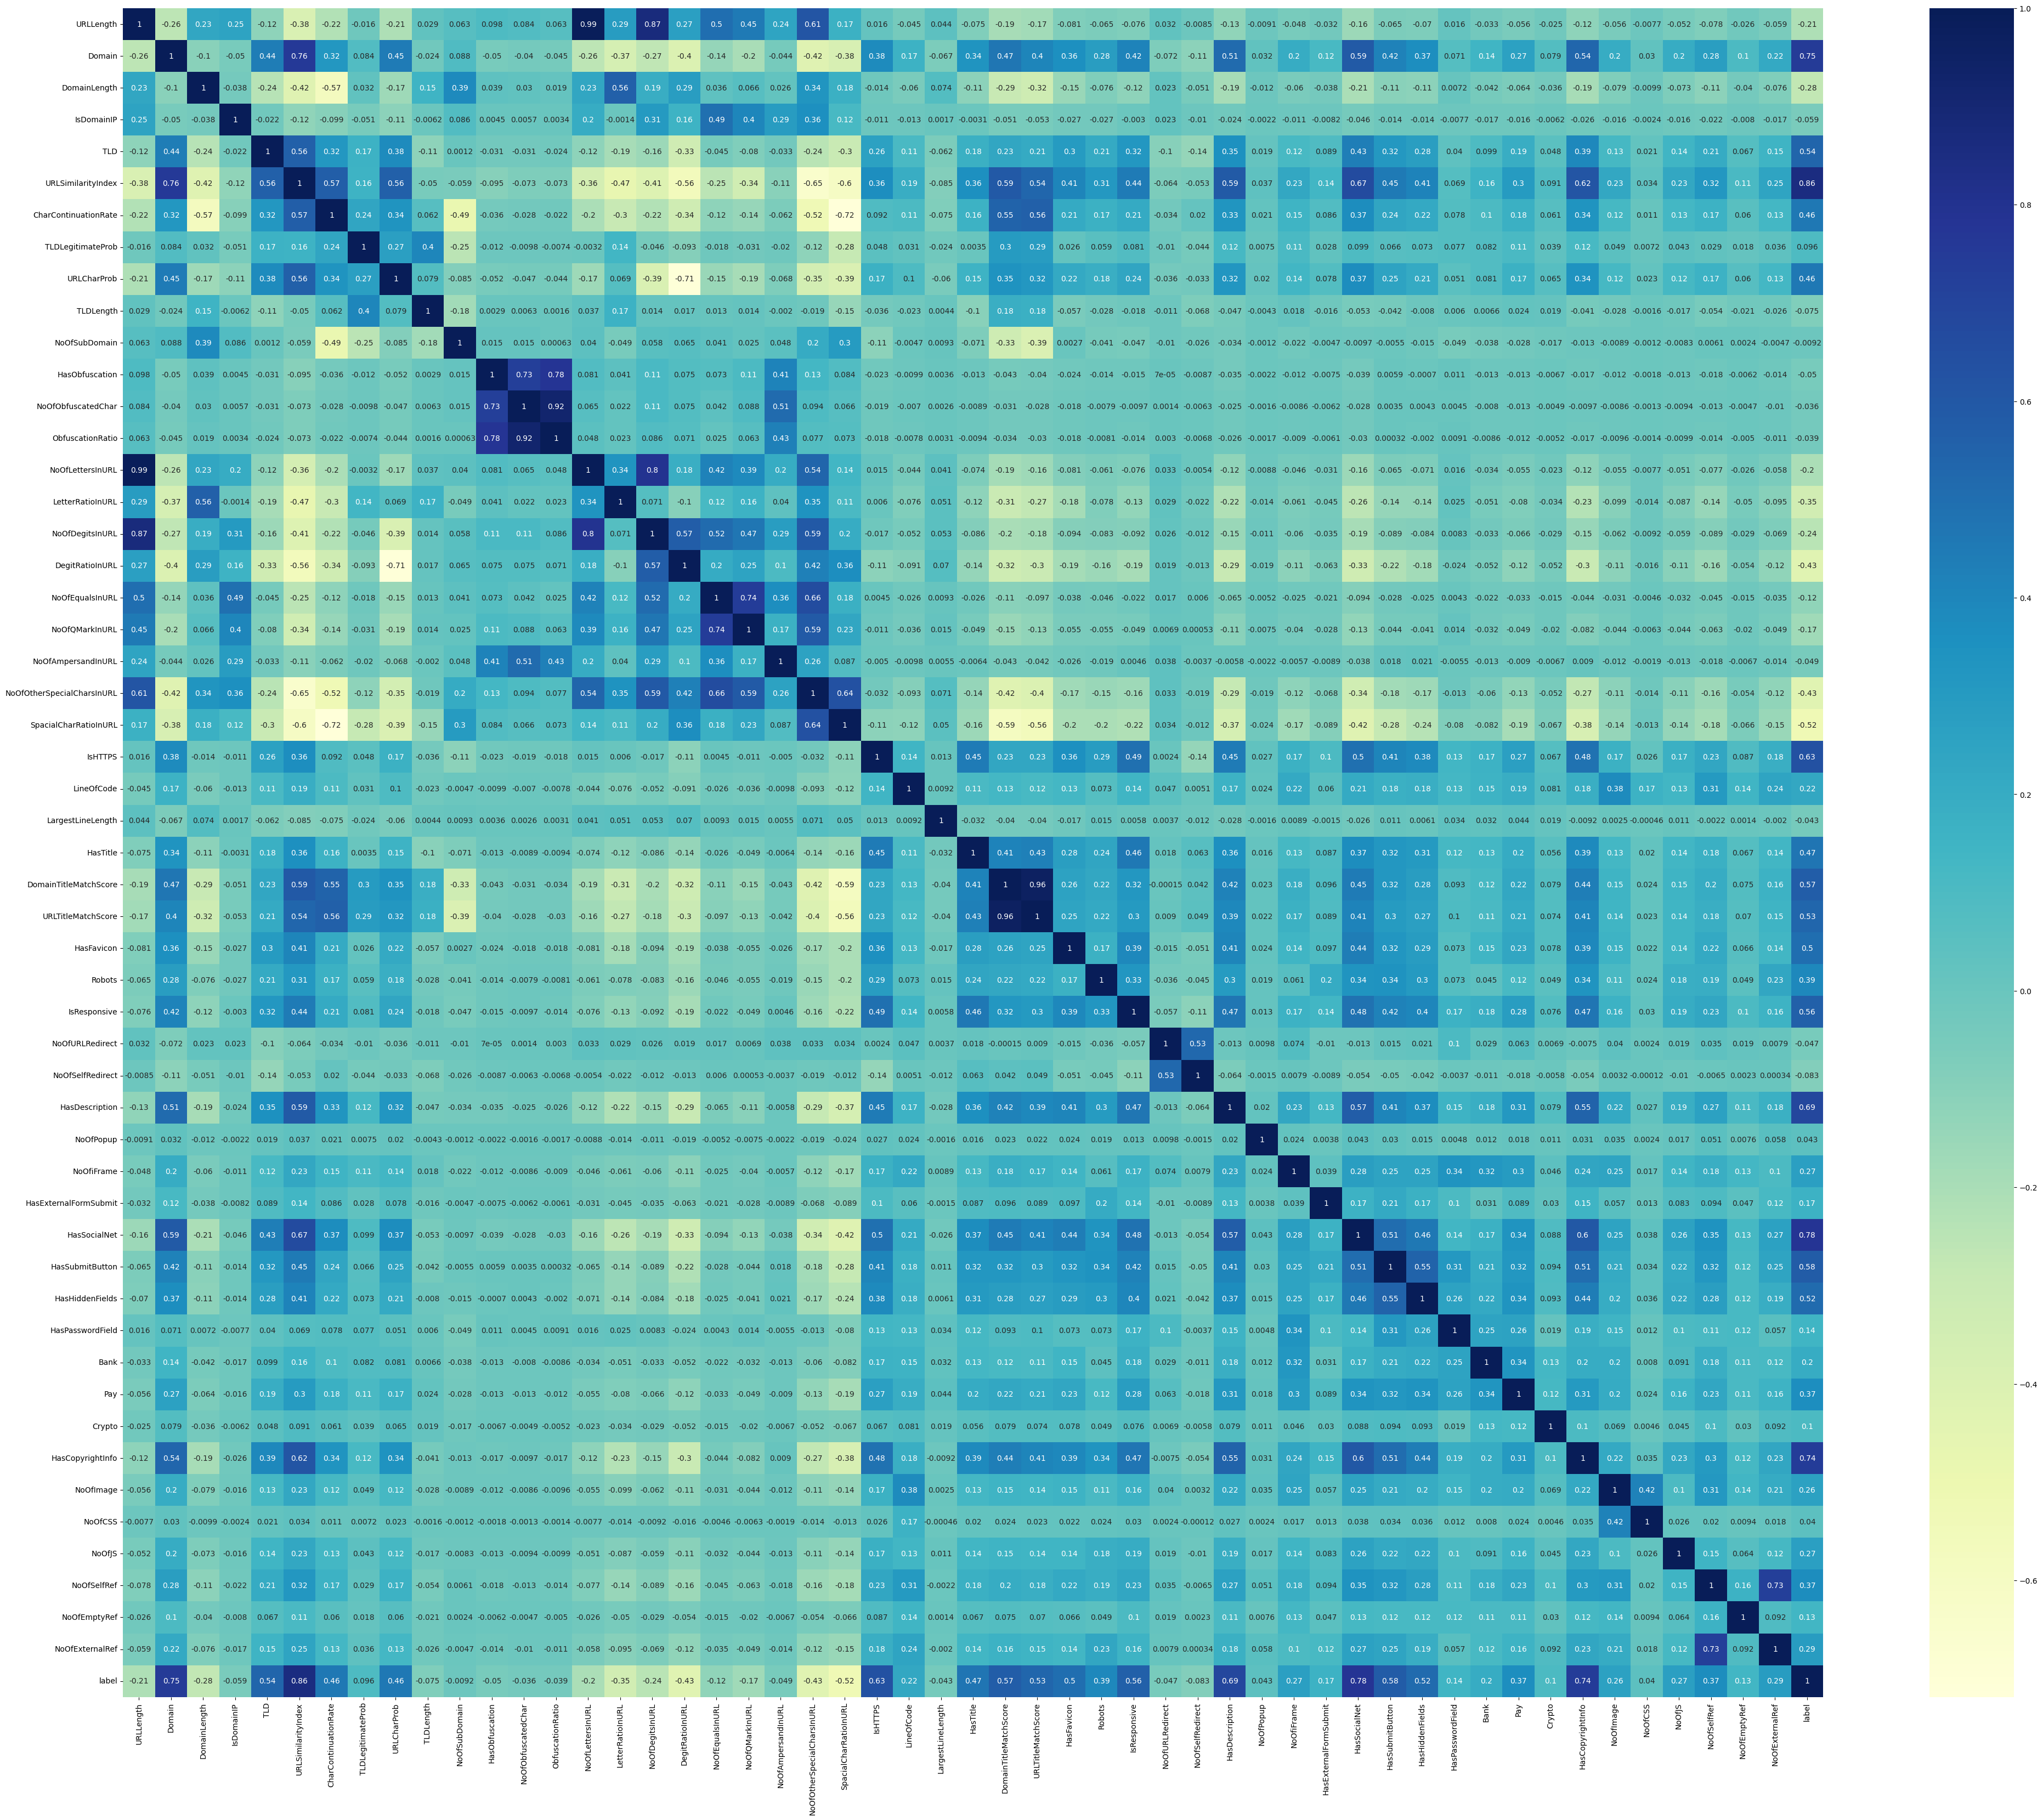

In [11]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
# Scaling data for heatmap
scalar=StandardScaler()
scalar.fit(data)
scaled_features = scalar.transform(data)
scaled_data= pd.DataFrame(scaled_features,columns=data.columns)

# Plotting heatmap
plt.figure(figsize=(50,40))
sns.heatmap(scaled_data.corr(),annot=True,cmap="YlGnBu")

For selecting the features, I took the features having good enough correlation with label. Since the columns that have high correlation with label also have high correlation with Domain, taking Domain would have been redundant, so I did not include it

Model and Feature set selection

In [12]:
# Threshold <=-0.4 to >=0.4
df_1 = data[['URLSimilarityIndex','CharContinuationRate','URLCharProb','SpacialCharRatioInURL','IsHTTPS','HasTitle','DomainTitleMatchScore','URLTitleMatchScore','HasFavicon','IsResponsive','HasDescription','HasSocialNet','HasSubmitButton','HasHiddenFields','HasCopyrightInfo','DegitRatioInURL','NoOfOtherSpecialCharsInURL','TLD']]

# Threshold <=-0.5 to >=0.5
df_2 = data[['URLSimilarityIndex','SpacialCharRatioInURL','IsHTTPS','DomainTitleMatchScore','URLTitleMatchScore','HasFavicon','IsResponsive','HasDescription','HasSocialNet','HasSubmitButton','HasHiddenFields','HasCopyrightInfo','TLD']]

# Threshold <=-0.6 to >=0.6
df_3 = data[['URLSimilarityIndex','IsHTTPS','HasDescription','HasSocialNet','HasCopyrightInfo']]

# Threshold <=-0.7 to >=0.7
df_4 = data[['URLSimilarityIndex','HasSocialNet','HasCopyrightInfo']]


I trained the data on 3 models:

LogisticRegression, for its simplicity
Ensemble models like RandomForestClassifier and XGBoost, since they tend to prevent overfitting and give accurate results

F1 Scores Table:
             Logistic Regression  Random Forest   XGBoost
Feature Set                                              
df_1                    0.999230       0.999941  0.999881
df_2                    0.999822       0.999881  0.999881
df_3                    0.999881       0.999881  0.999881
df_4                    0.997339       0.997339  0.997339


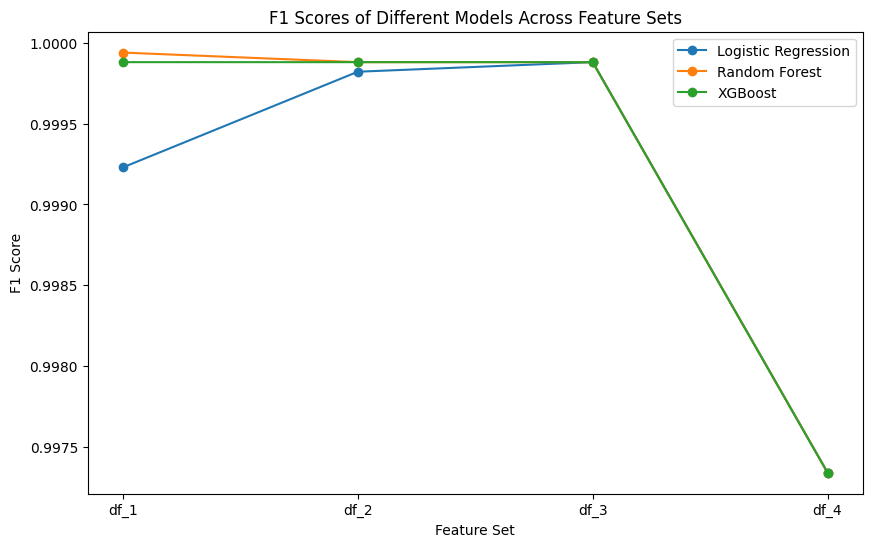

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

def split_train_test(X,model):
    # Splitting training and target data
    y=labels

    # Splitting data into test and train set
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

    # Training our model
    model.fit(X_train,y_train)

    # Predicting labels
    y_pred = model.predict(X_test)
    return f1_score(y_pred,y_test)

feature_sets = [("df_1", df_1), ("df_2", df_2), ("df_3", df_3), ("df_4", df_4)]

models = [
    ("Logistic Regression", LogisticRegression()),
    ("Random Forest", RandomForestClassifier(random_state=1)),
    ("XGBoost", xgb.XGBClassifier(random_state=1))
]

f1_scores = {model_name: [] for model_name, _ in models}
for model_name, model in models:
    for feature_set_name, feature_set in feature_sets:
        score = split_train_test(feature_set, model)
        f1_scores[model_name].append(score)

# Table
f1_scores_df = pd.DataFrame(f1_scores, index=[name for name, _ in feature_sets])
f1_scores_df.index.name = 'Feature Set'
print("F1 Scores Table:")
print(f1_scores_df)

# Plotting
x = range(len(feature_sets))
plt.figure(figsize=(10, 6))

# Plot F1 scores for each model
for model_name in f1_scores:
    plt.plot(x, f1_scores[model_name], marker='o', label=model_name)

plt.xticks(x, [name for name, _ in feature_sets])
plt.xlabel("Feature Set")
plt.ylabel("F1 Score")
plt.title("F1 Scores of Different Models Across Feature Sets")
plt.legend()
plt.show()

As per the above result, df_1 with RandomForestClassifier gives the best result

When I submitted the predictions with this model (previously when there was some discrepancy in the leaderboard scoring), I got a score of around 0.66736, which was too less as compared to the score I got while evaluating the model. From this I inferred probably my model was getting overfit. I submitted the predictions with combination of other feature sets and models I tested for above, but all of them gave a score around 0.66736 itself.

So I decided to slightly change my approach, instead of taking a lot of features, I decided to go with only Domain and apply NLP on it.

2. Approach 2 (NLP on Domain

In [14]:
# Loading dataset
data_nlp=pd.read_csv("/content/drive/MyDrive/train.csv")
data_nlp

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,mw205674.txt,http://www.danangluxury.com,26,www.danangluxury.com,20.0,0.0,com,75.000000,1.000000,0.522907,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,712147.txt,https://www.leedstownhall.co.uk,30,www.leedstownhall.co.uk,23.0,0.0,uk,100.000000,0.875000,0.028555,...,0.0,0.0,1.0,37.0,41.0,46.0,104.0,3.0,93.0,1.0
2,806061.txt,https://www.mexicancafe.co.nz,28,www.mexicancafe.co.nz,21.0,0.0,nz,100.000000,0.857143,0.001993,...,1.0,0.0,0.0,14.0,4.0,14.0,51.0,0.0,7.0,1.0
3,164934.txt,https://www.usglassmag.com,25,www.usglassmag.com,18.0,0.0,com,100.000000,1.000000,0.522907,...,1.0,0.0,1.0,40.0,26.0,25.0,106.0,9.0,193.0,1.0
4,8131216.txt,https://cloudflare-ipfs.com/ipfs/bafybeicivf4l...,93,cloudflare-ipfs.com,19.0,0.0,com,23.030879,0.733333,0.522907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71738,mw141563.txt,http://www.2k3d.csqoy.com,24,www.2k3d.csqoy.com,18.0,0.0,com,49.523810,0.700000,0.522907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71739,oph01779.txt,https://54e8ced5d334-shared.lowcodeunit.com/,43,54e8ced5d334-shared.lowcodeunit.com,35.0,0.0,com,28.489796,0.483871,0.522907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71740,812627.txt,https://www.mississippi-umc.org,30,www.mississippi-umc.org,23.0,0.0,org,100.000000,0.800000,0.079963,...,0.0,0.0,0.0,5.0,3.0,4.0,71.0,0.0,25.0,1.0
71741,38185.txt,https://www.sosoactive.com,25,www.sosoactive.com,18.0,0.0,com,100.000000,1.000000,0.522907,...,0.0,0.0,1.0,31.0,12.0,14.0,136.0,4.0,145.0,1.0


Preprocessing

In [15]:
# Taking categorical columns
df_nlp = data_nlp[['Domain','Title','TLD','label']]

# Dropping null values
df_nlp = df_nlp.dropna()

# Tokenizing the website domain
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
df_nlp['Tokenized_url'] = df_nlp['Domain'].apply(tokenizer.tokenize)

# Stemming the tokenized domain
stemmer = SnowballStemmer("english")
df_nlp['Stemmed_url'] = df_nlp['Tokenized_url'].map(lambda l:[stemmer.stem(word) for word in l])

# Combining the list of words with white space delimiter
df_nlp['text_sent'] = df_nlp['Stemmed_url'].map(lambda l:' '.join(l))
df_nlp.head()

,Domain,Title,TLD,label,Tokenized_url,Stemmed_url,text_sent
0,www.danangluxury.com,danangluxury,com,0.0,"[www, danangluxury, com]","[www, danangluxuri, com]",www danangluxuri com
1,www.leedstownhall.co.uk,leedstownhallco,uk,1.0,"[www, leedstownhall, co, uk]","[www, leedstownhal, co, uk]",www leedstownhal co uk
2,www.mexicancafe.co.nz,mexicacafeco,nz,1.0,"[www, mexicancafe, co, nz]","[www, mexicancaf, co, nz]",www mexicancaf co nz
3,www.usglassmag.com,usglassmag,com,1.0,"[www, usglassmag, com]","[www, usglassmag, com]",www usglassmag com
4,cloudflare-ipfs.com,0,com,0.0,"[cloudflare, ipfs, com]","[cloudflar, ipf, com]",cloudflar ipf com


Visualizing words in domain of legitimate and phishing websites using word clouds

Legitimate websites



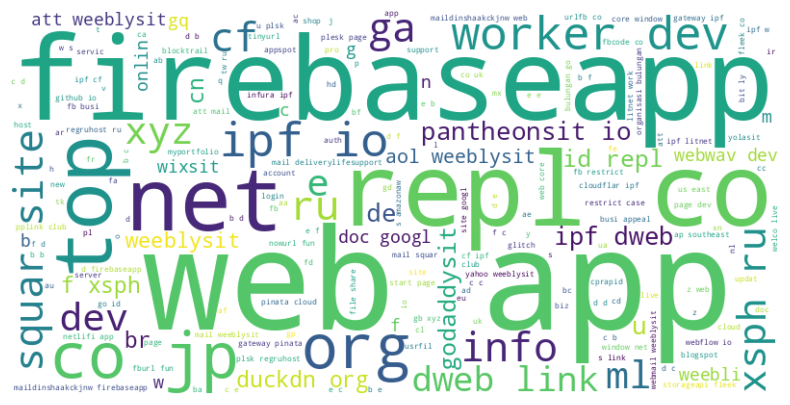


Phishing websites



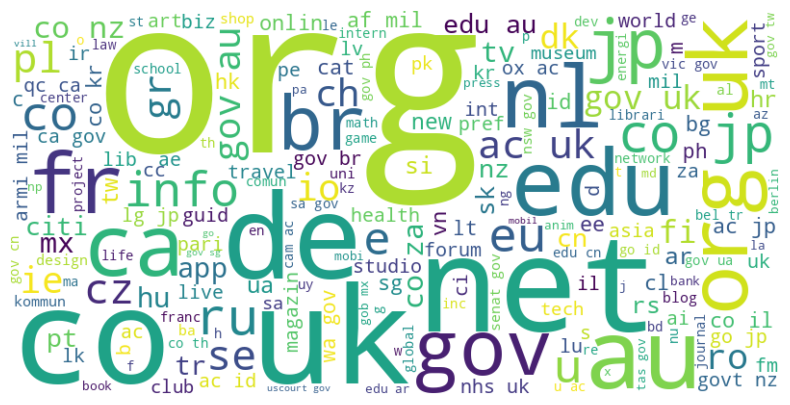

In [16]:
from wordcloud import WordCloud

# Taking legitimate and phishing websites in different dataframes
df_nlp_legit = df_nlp[df_nlp['label']==0]
df_nlp_phish = df_nlp[df_nlp['label']==1]

text_legit = ' '.join(df_nlp_legit['text_sent'])
text_phish = ' '.join(df_nlp_phish['text_sent'])

# Create the word cloud
wordcloud_legit = WordCloud(width=800, height=400, background_color='white').generate(text_legit)
wordcloud_phish = WordCloud(width=800, height=400, background_color='white').generate(text_phish)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_legit, interpolation='bilinear')
plt.axis('off')
print("Legitimate websites\n")
plt.show()

print()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_phish, interpolation='bilinear')
plt.axis('off')
print("Phishing websites\n")
plt.show()

Model selection

In [17]:
# Vectorizing the words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
cv = CountVectorizer()
df_nlp_vector = cv.fit_transform(df_nlp.text_sent)

# Splitting into training and testing data
trainX, testX, trainY, testY = train_test_split(df_nlp_vector, df_nlp.label)

# Model building
models_nlp = [LogisticRegression(),xgb.XGBClassifier(random_state=1),RandomForestClassifier(random_state=1)]

for model_nlp in models_nlp:
    model_nlp.fit(trainX,trainY)
    print(classification_report(model_nlp.predict(testX), testY))

              precision    recall  f1-score   support

         0.0       0.74      0.97      0.84      5676
         1.0       0.98      0.85      0.91     12260

    accuracy                           0.88     17936
   macro avg       0.86      0.91      0.88     17936
weighted avg       0.91      0.88      0.89     17936

              precision    recall  f1-score   support

           0       0.71      0.99      0.83      5314
           1       0.99      0.83      0.90     12622

    accuracy                           0.88     17936
   macro avg       0.85      0.91      0.87     17936
weighted avg       0.91      0.88      0.88     17936

              precision    recall  f1-score   support

         0.0       0.94      0.52      0.67     13318
         1.0       0.40      0.91      0.55      4618

    accuracy                           0.62     17936
   macro avg       0.67      0.72      0.61     17936
weighted avg       0.80      0.62      0.64     17936



3. Approach 3 (NLP + Numerical features)

In [18]:
# Model building using Logistic Regression
model_nlp = LogisticRegression()
model_nlp.fit(trainX,trainY)

# Adding nlp prediction probabilities of 'Domain' to the original data
data_nlp = data_nlp.dropna()
data_nlp['nlp_pred']=model_nlp.predict_proba(df_nlp_vector)[:,1]
data_nlp['nlp_pred'].head()

# Taking df_1 features from initial approach along with nlp_pred
labels_nlp = data_nlp['label']
data_nlp = data_nlp.drop(['label'],axis=1)
data_df_nlp = data_nlp[['URLSimilarityIndex','CharContinuationRate','URLCharProb','SpacialCharRatioInURL','IsHTTPS','HasTitle','DomainTitleMatchScore','URLTitleMatchScore','HasFavicon','IsResponsive','HasDescription','HasSocialNet','HasSubmitButton','HasHiddenFields','HasCopyrightInfo','DegitRatioInURL','NoOfOtherSpecialCharsInURL','nlp_pred']]
data_df_nlp.head()

,URLSimilarityIndex,CharContinuationRate,URLCharProb,SpacialCharRatioInURL,IsHTTPS,HasTitle,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,IsResponsive,HasDescription,HasSocialNet,HasSubmitButton,HasHiddenFields,HasCopyrightInfo,DegitRatioInURL,NoOfOtherSpecialCharsInURL,nlp_pred
0,75.000000,1.000000,0.049839,0.038,0.0,1.0,100.0,100.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,1.0,0.808357
1,100.000000,0.875000,0.058238,0.067,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.000,2.0,0.951608
2,100.000000,0.857143,0.065825,0.071,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.000,2.0,0.939250
3,100.000000,1.000000,0.058172,0.040,1.0,1.0,100.0,100.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000,1.0,0.832611
4,23.030879,0.733333,0.035517,0.054,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.118,5.0,0.000875


In [ ]:
Model selection

In [19]:
# Splitting training and target data
y_nlp=labels_nlp
X_nlp=data_df_nlp

# Splitting data into test and train set
X_train_nlp,X_test_nlp,y_train_nlp,y_test_nlp=train_test_split(X_nlp,y_nlp,test_size=0.2,random_state=1)
# Selecting model
model_df_nlp_1 = LogisticRegression()
model_df_nlp_2 = RandomForestClassifier(random_state=1)
model_df_nlp_3 = xgb.XGBClassifier(random_state=1)

# Training our models
model_df_nlp_1.fit(X_train_nlp,y_train_nlp)
model_df_nlp_2.fit(X_train_nlp,y_train_nlp)
model_df_nlp_3.fit(X_train_nlp,y_train_nlp)

# Predicting labels and calculating f1 score
y_pred_nlp_1 = model_df_nlp_1.predict(X_test_nlp)
y_pred_nlp_2 = model_df_nlp_2.predict(X_test_nlp)
y_pred_nlp_3 = model_df_nlp_3.predict(X_test_nlp)

print("Logistic Regression: ",f1_score(y_pred_nlp_1,y_test_nlp))
print("Random Forest: ",f1_score(y_pred_nlp_2,y_test_nlp))
print("XGBoost: ",f1_score(y_pred_nlp_3,y_test_nlp))

Logistic Regression:  0.9998814322978421
Random Forest:  0.9999407196632877
XGBoost:  0.9999407196632877


The score of Random Forest and XGBoost models almost same as using Random Forest in my initial approach. While I was working on this approach, the leaderboard scoring updated and my initial submission got a score of 0.99988 this time. The submission with third approach using XGBoost model was a bit lesser i.e 0.99977.

So as per my inferences from the approaches I used, Approach 1 worked for me the best overall

In [ ]:
Model building and training using Approach 1

In [20]:
# Splitting training and target data
y=labels
X=df_1

# Splitting data into test and train set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

model = RandomForestClassifier(random_state=1)

# Training our model
model.fit(X_train,y_train)

# Predicting labels and calculating f1 score
y_pred = model.predict(X_test)

f1_score(y_pred,y_test)

0.9999407196632877

Final Predictions

In [21]:
test_df=pd.read_csv("/content/drive/MyDrive/test.csv")
test_df

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
0,8095287.txt,http://marshy-sudden-couch.glitch.me/ghuve.htm,46,marshy-sudden-couch.glitch.me,29,0,me,33.392505,0.269231,0.003638,...,0,0,0,0,0,0,0,0,0,0
1,8138908.txt,https://blue-snowflake-573d.ovrchukicyvmee6167...,95,blue-snowflake-573d.ovrchukicyvmee6167.workers...,50,0,dev,12.878488,0.413043,0.000961,...,0,1,0,0,0,0,4,0,0,0
2,8058506.txt,https://mail34.godaddysites.com/at%26t-mail,43,mail34.godaddysites.com,23,0,com,40.526077,0.789474,0.522907,...,0,0,0,1,2,0,6,2,0,2
3,520305.txt,https://www.berntsen.com,23,www.berntsen.com,16,0,com,100.000000,1.000000,0.522907,...,0,1,0,1,12,4,9,353,0,336
4,mw10079.txt,http://www.poczta.blocktrail.com,31,www.poczta.blocktrail.com,25,0,com,61.080190,0.647059,0.522907,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,mw4286.txt,http://www.document-buh.com,26,www.document-buh.com,20,0,com,72.126105,0.750000,0.522907,...,0,0,0,0,0,0,0,0,0,0
29996,643720.txt,https://www.artxzay.com,22,www.artxzay.com,15,0,com,100.000000,1.000000,0.522907,...,1,1,0,1,27,3,24,102,0,11
29997,452512.txt,https://www.truthaboutdeath.com,30,www.truthaboutdeath.com,23,0,com,100.000000,1.000000,0.522907,...,0,0,0,1,29,2,6,65,0,29
29998,7997647.txt,https://novo-sicredi-black.com/?page=home&amp;...,337,novo-sicredi-black.com,22,0,com,3.656771,0.444444,0.522907,...,0,0,0,0,1,5,11,0,0,5


In [22]:
# Dropping null values
test_df = test_df.dropna()

# Dropping categorical data
filenames = test_df['FILENAME']
test_df = test_df.drop(['FILENAME','URL','Domain','Title'],axis=1)

# Encoding TLD Column
test_df['TLD'] = encoder.transform(test_df['TLD'])
test_df = test_df[['URLSimilarityIndex','CharContinuationRate','URLCharProb','SpacialCharRatioInURL','IsHTTPS','HasTitle','DomainTitleMatchScore','URLTitleMatchScore','HasFavicon','IsResponsive','HasDescription','HasSocialNet','HasSubmitButton','HasHiddenFields','HasCopyrightInfo','DegitRatioInURL','NoOfOtherSpecialCharsInURL','TLD']]

# Predicting labels
prediction = model.predict(test_df)
prediction

array([0., 0., 0., ..., 1., 0., 1.])

In [23]:
# Create submission.csv file with the predictions
submission=pd.DataFrame()
submission['FILENAME']=filenames
submission['label'] = prediction
submission.to_csv('submission_10-11-24_00:24.csv',index=False)
submission

,FILENAME,label
0,8095287.txt,0.0
1,8138908.txt,0.0
2,8058506.txt,0.0
3,520305.txt,1.0
4,mw10079.txt,0.0
...,...,...
29995,mw4286.txt,0.0
29996,643720.txt,1.0
29997,452512.txt,1.0
29998,7997647.txt,0.0
